## Install Fenics

In [1]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2022-08-10 15:34:09--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2831 (2.8K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   2.76K  --.-KB/s    in 0s      

2022-08-10 15:34:10 (25.5 MB/s) - ‘/tmp/fenics-install.sh’ saved [2831/2831]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh == http* ]]
+ PYBIND11_

In [ ]:
# Add FEniCS PPA to Ubuntu and install (Python3.6)
!echo deb http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic main >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 2C5275D7EF63D9DE2D28D3702940F5212B746472
!apt-get -qq update

!apt-get -y install fenics > /dev/null

# Reinstall dolfin for Python3.7
!rm -r /usr/lib/petsc/lib/python3/dist-packages/dolfin
!git clone https://bitbucket.org/fenics-project/dolfin
!cd dolfin/python && python3 setup.py install

# Reinstall mpi4py for Python3.7
!rm -r /usr/lib/python3/dist-packages/mpi4py*
!pip3 install mpi4py --upgrade

Executing: /tmp/apt-key-gpghome.zmApbrBX5v/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 2C5275D7EF63D9DE2D28D3702940F5212B746472
gpg: key 2940F5212B746472: public key "Launchpad PPA for FEniCS Packages Team" imported
gpg: Total number processed: 1
gpg:               imported: 1
Extracting templates from packages: 100%
Cloning into 'dolfin'...
Receiving objects: 100% (239624/239624), 50.08 MiB | 19.46 MiB/s, done.
Resolving deltas: 100% (183672/183672), done.
running install
running bdist_egg
running egg_info
creating fenics_dolfin.egg-info
writing fenics_dolfin.egg-info/PKG-INFO
writing dependency_links to fenics_dolfin.egg-info/dependency_links.txt
writing requirements to fenics_dolfin.egg-info/requires.txt
writing top-level names to fenics_dolfin.egg-info/top_level.txt
writing manifest file 'fenics_dolfin.egg-info/SOURCES.txt'
writing manifest file 'fenics_dolfin.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_p

In [ ]:
# Installing and Importing Fenics
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
    from fenics import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from fenics import *; from mshr import *
    
dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2019.2.0.dev0


## Self Assembly Coupled with Mechanics

In [5]:
"""
Created on Sat Jan 2 22:23:19 2021
# change mechanic behaviour
viscous behaviour ekle

@author: bilginkocak
"""

import random
from dolfin import *
import numpy as np

class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):
        if (x[0]-0.5)**2 + (x[1]-0.5)**2  <= 0.125:
            values[2] = np.sin(15*np.pi*x[0])
        else:
            values[2] = -0.2 #+ 0.2*(0.5 - random.random())
        values[1] = 0.0
        if (x[0]-0.5)**2 + (x[1]-0.5)**2 <= 0.125:
            values[0] = 0.6 #+ 0.2*(0.5 - random.random())
        else:
            values[0] = -0.6 #+ 0.2*(0.5 - random.random())
        values[3] = values[2]
        values[1] = values[0]
        values[4] = 0
        values[5] = 0
    def value_shape(self):
        return (6,)

class CahnHilliardEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)

class RightBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 1.0)
class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)
def all(x, on_boundary):
    return on_boundary 

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["quadrature_degree"] = 5

# Create mesh and build function space
mesh = UnitSquareMesh.create(80, 80, CellType.Type.triangle)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
V = VectorElement("Lagrange", mesh.ufl_cell(),1)
TH = MixedElement([P1, P1, P1, P1, V])
ME = FunctionSpace(mesh, TH)

bc = DirichletBC(ME.sub(4),Constant((0,0)),all)

boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim() - 1, 0)
rightBoundary = RightBoundary()
leftBoundary = LeftBoundary()
rightBoundary.mark(boundary_markers, 1)
leftBoundary.mark(boundary_markers, 2)
k = 1
rightTraction = Expression(('-k*(x[0]-1.0)','0.0'),degree=1,k=k)
leftTraction = Expression(('-k*x[0]','0.0'),degree=1,k=k)

dt = 5.0e-5  # time step
tend = 0.01
num = int(tend/dt) + 1
time_array = np.linspace(0,tend, num)
# epsv = 0.02
# epsu = 0.05
# tu = 1
# tv = 100
# beta = -0.8
# alpha = 0.3
# sigma = 500
epsv = 0.025
epsu = 0.025
tu = 1
tv = 10
beta = -0.8
alpha = 0.3
sigma = 100

G = 4 #4.225e5
K = 6 #2e6

tao = Constant(0.2)
mu = Constant(G)
traction = Constant((0, 0))
kappa = K


# Define trial and test functions
du    = TrialFunction(ME)
q1, q2, q3, q4, q5  = TestFunctions(ME)

# Define functions
uu   = Function(ME)  # current solution
uu0  = Function(ME)  # solution from previous converged step
uu00  = Function(ME)  # to get initial concentration

# Split mixed functions
dc1, dmu1, dc2, dmu2, du = split(du)
c1,  mu1, c2, mu2, u  = split(uu)
c10, mu10, c20, mu20, u0 = split(uu0)
_, _, c200, _, _ = split(uu0)

# Create intial conditions and interpolate
u_init = InitialConditions(degree=2)
uu.interpolate(u_init)
uu0.interpolate(u_init)
uu00.interpolate(u_init)

# Mechanical Effect
d = len(u)
gamma = Constant(3)
nu = Constant(0.3)
beta1 = Constant(2*nu/(1-2*nu))
omega = Constant(1)

def transformC(c):
  return (c-(-1))/2

I = Identity(d)
Jc = 1 + omega*(transformC(c2)-transformC(c200))   #Bir önceki time step Jc si olmalı
F = I + grad(u)
Fn = I + grad(u0)
C = F.T*F
Cn = Fn.T*Fn 
Fmech = pow(Jc, -1/3)*F
Fnmech = pow(Jc, -1/3)*Fn

J = det(Fmech)
Fmech_ = pow(J,-1/3)*Fmech
fnmech_ = pow(J, -1/3)*Fnmech


def DEV(Tensor, C):
  return Tensor - 1/3*inner(Tensor,C)*inv(C)

def CalcQ(u_old, u, Qn, c2, c200):
    I = Identity(ME.mesh().geometry().dim()) 
    Jc = 1 + omega*(transformC(c2)-transformC(c200))
    Fn = I + grad(u_old)
    Fn = pow(Jc, -1/3)*Fn
    C_old = Fn.T*Fn
    F = I + grad(u)          ### Deformation gradient
    F = pow(Jc, -1/3)*F
    J = det(F)
    C = F.T*F               ### Deformation tensor
    F_ = pow(J, -1/3)*F; F_n = pow(J, -1/3)*Fn
    Se_iso = inv(F)*mu*dev(F_*F_.T)*inv(F.T)
    Se_ison = inv(Fn)*mu*dev(F_n*F_n.T)*inv(Fn.T)
    Q = (Qn/dt + beta*(DEV(Se_iso,C) - DEV(Se_ison,C_old))/dt)/(1/dt + 1/tao)
    return Q

WF = TensorFunctionSpace(mesh, "DG", degree=0)
I = Identity(WF.mesh().geometry().dim())
Qn = interpolate(Constant(((0,0),(0,0))), WF) 

Q = CalcQ(u0, u, Qn, c2, c200)

Svol = inv(F)*J*1/2*kappa*(J - 1/J)*I*inv(F.T)
Se_iso = inv(F)*mu*dev(Fmech_*Fmech_.T)*inv(F.T)

Siso_ = Se_iso + Q

#To = kappa/2*(pow(J,2) - 1)*I + mu*dev(Fmech_*Fmech_.T)
#P = To*inv(F.T)
S = pow(Jc, -1/3)*(Svol + pow(J, -2/3)*DEV(Siso_ ,C))
P = F*S
p = -1/3*inner(P, F)

#dpsi_mech_dFmech = 1/2*kappa*(pow(J, 2) - 1)*inv(Fmech.T) + mu*Fmech
#dpsi_dFmech = pow(Jc, -1/3)*dpsi_mech_dFmech
#p = -1/3*pow(Jc, -1/3)*inner(dpsi_mech_dFmech, F)
#P = dpsi_dFmech

# change mechanic behaviour (original)
#dpsi_mech_dFmech = gamma*(Fmech - pow(det(Fmech), -beta1)*inv(Fmech).T)
#dpsi_dFmech = pow(Jc, -1/3)*dpsi_mech_dFmech
#p = -1/3*pow(Jc, -1/3)*inner(dpsi_mech_dFmech, F)
#dpsi_dc = A*ln(c/(1-c)) + B*(1 - 2*c) + omega*p/Jc  #-1/3*pow(Jc,-4/3)*omega*inner(dpsi_el_dFe,F)#
#P = dpsi_dFmech

f1 = (1-c1)*(1+c1)*c1 - alpha*c2 - beta*c2**2
f2 = (1-c2)*(1+c2)*c2 - alpha*c2 - 2*beta*c1*c2 + omega*p/Jc
vbar = assemble(uu.split()[2]*dx)/assemble(1*dx(mesh))
# vbar = 0.0114559
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

L0 = c1*q1*dx - c10*q1*dx - dt*dot(grad(mu1),grad(q1))*dx
L1 = mu1*q2*dx + epsu**2*dot(grad(c1),grad(q2))*dx - f1*q2*dx
L2 = c2*q3*dx - c20*q3*dx - dt*dot(grad(mu2),grad(q3))*dx + dt*sigma*(c2-vbar)*q3*dx
L3 = mu2*q4*dx + epsv**2*dot(grad(c2),grad(q4))*dx - f2*q4*dx
L4 = inner(P, grad(q5))*dx - dot(-k*u,q5)*ds(2) - dot(-k*u,q5)*ds(1)
#L4 = inner(P, grad(q5))*dx - dot(leftTraction,q5)*ds(2) - dot(rightTraction,q5)*ds(1)
L = L0 + L1 + L2 + L3 + L4
# Output file
file_results = XDMFFile(f"./FLVE_BCP/coupled-ch.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

def save_to_file(uu, t):
    _c1,  _mu1, _c2, _mu2, _u = uu.split()
    _u.rename("d", "deformation u")
    _c1.rename("u", "u field")
    _c2.rename("v", "v field")
    _mu1.rename("mu_u", "chemical potential u")
    _mu2.rename("mu_v", "chemical potential v")
    file_results.write(_c1, t)
    file_results.write(_mu1, t)
    file_results.write(_c2, t)
    file_results.write(_mu2, t)
    file_results.write(_u, t)

t = 0
count = 0
for t in time_array:
    save_to_file(uu,t)
    # if t<0.001 and count%10 == 0:
    #     save_to_file(uu,t)
    # if t>=0.001 and count%100 == 0:
    #     save_to_file(uu,t)
    solve(L==0, uu, solver_parameters={"newton_solver":{"linear_solver":"lu",
                                                                        "relative_tolerance": 1e-6,
                                                                        #"preconditioner":"ilu",
                                                                        "convergence_criterion":"incremental",
                                                                        }})
    # Update Q
    Q = Q = CalcQ(split(uu0)[4], split(uu)[4], Qn, split(uu)[2], c200)  #olmazsa uu dan split et
    Q_proj = project(Q, WF)
    Qn.vector()[:] = Q_proj.vector()
    if count%10 == 0:
      print("time = " + str(t))
    uu0.assign(uu)
    count += 1

time = 0.0
time = 0.0005
time = 0.001
time = 0.0015
time = 0.002
time = 0.0025
time = 0.003
time = 0.0035
time = 0.004
time = 0.0045000000000000005
time = 0.005
time = 0.0055000000000000005
time = 0.006
time = 0.006500000000000001
time = 0.007
time = 0.007500000000000001
time = 0.008
time = 0.0085
time = 0.009000000000000001
time = 0.0095
time = 0.01


In [ ]:
assemble(uu0.split()[2]*dx)/assemble(1*dx(mesh))

-0.11965367527385821

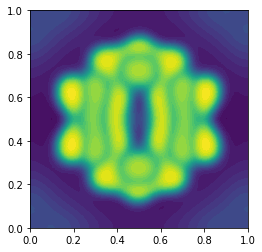

In [6]:
plot(uu.split()[0])

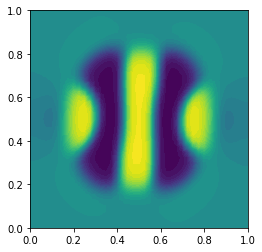

In [ ]:
plot(uu.split()[2])

In [ ]:
!zip -r /content/file.zip /content/ecch

  adding: content/ecch/ (stored 0%)
  adding: content/ecch/v000049.vtu (deflated 86%)
  adding: content/ecch/u000000.vtu (deflated 91%)
  adding: content/ecch/v.pvd (deflated 89%)
  adding: content/ecch/d000069.vtu (deflated 81%)
  adding: content/ecch/d000067.vtu (deflated 81%)
  adding: content/ecch/d000059.vtu (deflated 81%)
  adding: content/ecch/v000008.vtu (deflated 86%)
  adding: content/ecch/d000062.vtu (deflated 81%)
  adding: content/ecch/d000079.vtu (deflated 81%)
  adding: content/ecch/d000032.vtu (deflated 81%)
  adding: content/ecch/v000019.vtu (deflated 86%)
  adding: content/ecch/v000078.vtu (deflated 86%)
  adding: content/ecch/u000090.vtu (deflated 86%)
  adding: content/ecch/d000078.vtu (deflated 81%)
  adding: content/ecch/u000005.vtu (deflated 86%)
  adding: content/ecch/d000061.vtu (deflated 81%)
  adding: content/ecch/v000006.vtu (deflated 86%)
  adding: content/ecch/v000040.vtu (deflated 86%)
  adding: content/ecch/u000078.vtu (deflated 86%)
  adding: content/ec